<a href="https://colab.research.google.com/github/manginoja/455/blob/main/ResNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Do some imports and upload the json file for getting Kaggle data

In [10]:
!pip install --upgrade --force-reinstall --no-deps kaggle
!pip install -U fastai

import torch
import torchvision
from torchvision import *
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pandas as pd
from fastai.vision.all import *
from fastai.data.core import DataLoaders
from google.colab import files

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

files.upload()
!mkdir ~/.kaggle
!mv ./kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle competitions download -c birds-22wi

!unzip birds-22wi.zip

  Using cached kaggle-1.5.12-py3-none-any.whl
  Attempting uninstall: kaggle
    Found existing installation: kaggle 1.5.12
    Uninstalling kaggle-1.5.12:
      Successfully uninstalled kaggle-1.5.12


KeyboardInterrupt: ignored

# Transform and retrieve data

In [12]:
def get_bird_data():
  # Data augmentation transformations. Not for Testing!
  resize = 224 # probably a good size because resnet is trained on 224 x 224 images
  transform_train = transforms.Compose([
    transforms.Resize((resize, resize)),
    transforms.RandomCrop(112, padding=4, padding_mode='edge'), # Take 112x112 crops from 120x120 padded images
    transforms.RandomHorizontalFlip(),    # 50% of time flip image along y-axis 2 -> 5
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
  ])

  transform_test = transforms.Compose([
    transforms.Resize((resize, resize)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
  ])


  full_set = torchvision.datasets.ImageFolder(root='./birds/train', transform=transform_train)

  train_size = int(0.8 * len(full_set))
  test_size = int((len(full_set) - train_size) / 2)
  valid_size = test_size + 1
  train_set, test_set, valid_set = torch.utils.data.random_split(full_set, [train_size, test_size, valid_size])
  trainloader = torch.utils.data.DataLoader(train_set, batch_size=128, shuffle=True, num_workers=2)
  testloader = torch.utils.data.DataLoader(test_set, batch_size=128, shuffle=False, num_workers=2)
  validloader = torch.utils.data.DataLoader(valid_set, batch_size=128, shuffle=False, num_workers=2)
  
  csv = pd.read_csv('./birds/labels.csv')
  classes = csv['class'].unique()
  return {'train': trainloader, 'valid': validloader, 'test': testloader, 'classes': classes}

data = get_bird_data()

# Set up the model

In [13]:
use_cuda = True
net = models.resnet50(pretrained=True)
net = net.cuda() if use_cuda else net

In [14]:
in_feat = net.fc.in_features
net.fc = nn.Linear(in_feat, 555)
net.fc = net.fc.cuda() if device else net.fc

# Training and accuracy function

In [15]:
def train(net, dataloader, validloader, epochs=1, lr=0.01, momentum=0.9, decay=0, verbose=1):
  net.to(device)
  net.train()
  losses = []
  valid_losses = []
  
  criterion = nn.CrossEntropyLoss() # Combination softmax + negative log likelihood
  optimizer = optim.SGD(net.parameters(), lr=lr, momentum=momentum, weight_decay=decay)
  for epoch in range(epochs):
    net.train()
    sum_loss = 0.0
    for i, batch in enumerate(dataloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = batch[0].to(device), batch[1].to(device)
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize 
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()  # autograd magic, computes all the partial derivatives
        optimizer.step() # takes a step in gradient direction

        # print statistics
        losses.append(loss.item())
        sum_loss += loss.item()
        #if i % 100 == 99:    # print every 100 mini-batches
        if verbose:
          print('[%d, %5d] loss: %.3f' %
              (epoch + 1, i + 1, sum_loss / 100))
        sum_loss = 0.0
    for i, batch in enumerate(validloader, 0):
      with torch.no_grad():
        net.eval()
      # get the inputs; data is a list of [inputs, labels]
        inputs, labels = batch[0].to(device), batch[1].to(device)

        # forward + backward + optimize 
        outputs = net(inputs)
        loss = criterion(outputs, labels)

        # print statistics
        valid_losses.append(loss.item())
        sum_loss += loss.item()
        #if i % 100 == 99:    # print every 100 mini-batches
        if verbose:
          print('[%d, %5d] loss: %.3f' %
              (epoch + 1, i + 1, sum_loss / 100))
        sum_loss = 0.0
  return losses, valid_losses

def accuracy(net, dataloader):
  correct = 0
  total = 0
  net.to(device)
  net.eval()
  with torch.no_grad():
      for batch in dataloader:
          images, labels = batch[0].to(device), batch[1].to(device)
          outputs = net(images)
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()
  return correct/total

# Finding optimal LR

SuggestedLRs(valley=6.918309736647643e-06)

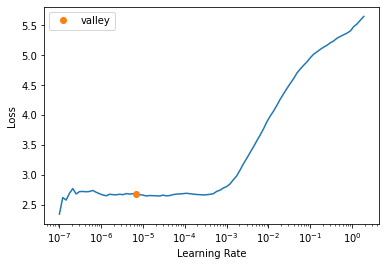

In [ ]:
dls = DataLoaders.from_dsets(train_set, valid_set)
learn = Learner(dls, net, loss_func=nn.CrossEntropyLoss(), wd=0.0005)
learn.lr_find()

# Train!

In [19]:
#net.load_state_dict(torch.load('birds4.pth'))
losses, valid_losses = train(net, data['train'], data['valid'], epochs=30, lr=.001, decay = 0.0005)

Streaming output truncated to the last 5000 lines.
[12,   188] loss: 0.017
[12,   189] loss: 0.016
[12,   190] loss: 0.016
[12,   191] loss: 0.016
[12,   192] loss: 0.016
[12,   193] loss: 0.017
[12,   194] loss: 0.015
[12,   195] loss: 0.016
[12,   196] loss: 0.016
[12,   197] loss: 0.017
[12,   198] loss: 0.018
[12,   199] loss: 0.020
[12,   200] loss: 0.017
[12,   201] loss: 0.015
[12,   202] loss: 0.018
[12,   203] loss: 0.016
[12,   204] loss: 0.018
[12,   205] loss: 0.017
[12,   206] loss: 0.017
[12,   207] loss: 0.017
[12,   208] loss: 0.018
[12,   209] loss: 0.017
[12,   210] loss: 0.019
[12,   211] loss: 0.017
[12,   212] loss: 0.015
[12,   213] loss: 0.015
[12,   214] loss: 0.015
[12,   215] loss: 0.018
[12,   216] loss: 0.016
[12,   217] loss: 0.015
[12,   218] loss: 0.015
[12,   219] loss: 0.019
[12,   220] loss: 0.016
[12,   221] loss: 0.015
[12,   222] loss: 0.019
[12,   223] loss: 0.016
[12,   224] loss: 0.017
[12,   225] loss: 0.015
[12,   226] loss: 0.019
[12,   227] l

# Plot accuracy

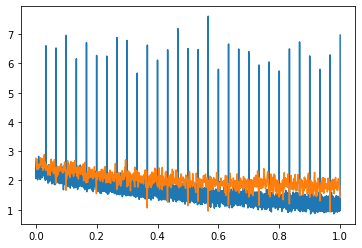

In [21]:
#torch.save(net.state_dict(), "birds4.pth")
x1 = np.linspace(0, 1, 242 * 30)
x2 = np.linspace(0, 1, 31 * 30)
plt.plot(x1, losses)
plt.plot(x2, valid_losses)

#print("Training accuracy: %f" % accuracy(net, data['train']))
#print("Testing  accuracy: %f" % accuracy(net, data['test']))

https://stackoverflow.com/questions/31003155/plotting-two-different-arrays-of-different-lengths

# Put into submission for Kaggle

In [ ]:
net.eval()

transform_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
  ])

help_set = torchvision.datasets.ImageFolder(root='./birds/train', transform=transform_test)
help_dict = help_set.class_to_idx
full_set = torchvision.datasets.ImageFolder(root='./birds/test', transform=transform_test)
testloader = torch.utils.data.DataLoader(full_set, batch_size=1, shuffle=False)
better_help_dict = dict((y,x) for x,y in help_dict.items())

prediction = []
files = []

with torch.no_grad():
  for i, (images, labels) in enumerate(testloader, 0):
    images, labels = images.to(device), labels.to(device)
    outputs = net(images)
    predicted = torch.max(outputs, 1)[1]
    for num in range(len(labels)):
      prediction.append(predicted[num].item())
  for i in range(10000):
    sample_fname, _ = testloader.dataset.samples[i]
    file_name = str(sample_fname)
    file_name = "test" + file_name[14 : len(file_name)]
    files.append(file_name)


for i in range(len(prediction)):
  prediction[i] = int(better_help_dict[prediction[i]])

Streaming output truncated to the last 5000 lines.
166
46
442
379
338
348
64
88
111
178
273
34
511
553
535
18
166
191
79
151
549
6
369
267
450
296
373
518
248
333
348
373
524
34
175
176
398
240
286
155
300
197
66
415
503
14
271
458
182
264
503
0
73
206
442
425
45
209
442
451
377
267
286
446
491
279
91
20
440
528
265
482
442
310
83
170
98
238
371
243
494
68
215
541
74
553
445
304
137
112
239
506
308
452
154
262
464
521
176
245
199
314
18
75
52
207
279
54
17
539
69
299
513
349
476
520
269
196
401
8
119
501
207
436
121
322
490
412
346
519
210
139
450
19
53
255
509
435
8
528
77
106
533
456
388
163
166
150
64
133
178
462
221
43
176
286
242
106
515
352
238
119
385
554
400
507
499
317
171
281
293
7
118
334
134
110
241
212
304
420
294
174
299
79
161
102
507
239
421
136
462
62
462
223
323
451
409
271
218
198
547
486
228
435
492
371
300
93
302
478
8
384
211
415
166
47
535
262
145
396
299
64
187
68
380
506
473
368
196
50
346
98
501
367
92
504
349
33
509
114
331
51
69
345
369
50
396
57
67
136
48
2

In [ ]:
my_submission = pd.DataFrame({'path': files, 'class': prediction})
my_submission.to_csv('submission.csv', index=False)

186
